In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
# Dataset

path = "E:/Research/Ovarian Cancer/Articles/Orginal/"
data = pd.read_excel(path+"data_ready.xlsx")

df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
data.shape

(2675, 7)

In [4]:
df_train.head()

,Age,Grading,Histology,Type,Status,MonthSurvive,YearSurvive
1,0.000000,1.0,Germ cell,Germ cell,1.0,65,6
2,0.000000,9.0,Non-specific,Non-specific,0.0,74,7
3,0.139726,9.0,Sex cord-stromal,Sex cord-stromal,1.0,41,4
4,0.287671,9.0,Non-specific,Non-specific,1.0,54,5
5,0.616438,9.0,Non-specific,Non-specific,0.0,85,8


In [5]:
# Feature transformers

cols_standardize = ['Age']
cols_onehotencoded = ['Grading', 'Histology', 'Type']

standardize = [([col], StandardScaler()) for col in cols_standardize]
onehot_encoded = [([col], OneHotEncoder(handle_unknown='ignore')) for col in cols_onehotencoded]

#encoded = [([col], LabelEncoder()) for col in cols_labelencoded]
#leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + onehot_encoded)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
# label transforms

num_durations = 10
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df['YearSurvive'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [8]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [9]:
# neural net

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [10]:
net

MLPVanilla(
  (net): Sequential(
    (0): DenseVanillaBlock(
      (linear): Linear(in_features=25, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): DenseVanillaBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [10]:
# model training

model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

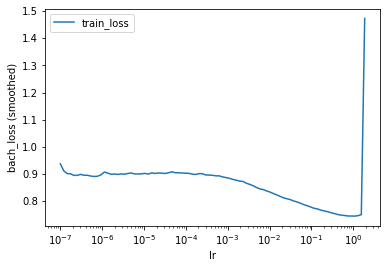

In [11]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [12]:
lr_finder.get_best_lr()

0.10722672220103299

In [13]:
model.optimizer.set_lr(0.01)

In [14]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.7225,	val_loss: 0.6372
1:	[0s / 0s],		train_loss: 0.6201,	val_loss: 0.6198
2:	[0s / 0s],		train_loss: 0.6019,	val_loss: 0.6122
3:	[0s / 0s],		train_loss: 0.5909,	val_loss: 0.6078
4:	[0s / 0s],		train_loss: 0.5765,	val_loss: 0.6009
5:	[0s / 0s],		train_loss: 0.5761,	val_loss: 0.5981
6:	[0s / 0s],		train_loss: 0.5710,	val_loss: 0.5976
7:	[0s / 0s],		train_loss: 0.5673,	val_loss: 0.5999
8:	[0s / 0s],		train_loss: 0.5664,	val_loss: 0.5942
9:	[0s / 0s],		train_loss: 0.5608,	val_loss: 0.5987
10:	[0s / 0s],		train_loss: 0.5581,	val_loss: 0.6061
11:	[0s / 0s],		train_loss: 0.5554,	val_loss: 0.6029
12:	[0s / 0s],		train_loss: 0.5526,	val_loss: 0.5926
13:	[0s / 0s],		train_loss: 0.5502,	val_loss: 0.5902
14:	[0s / 0s],		train_loss: 0.5495,	val_loss: 0.5880
15:	[0s / 1s],		train_loss: 0.5486,	val_loss: 0.5852
16:	[0s / 1s],		train_loss: 0.5437,	val_loss: 0.5917
17:	[0s / 1s],		train_loss: 0.5446,	val_loss: 0.5878
18:	[0s / 1s],		train_loss: 0.5423,	val_loss: 0.5924
19:

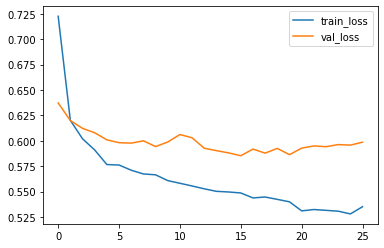

In [15]:
_ = log.plot()

In [16]:
# prediction

surv = model.predict_surv_df(x_test)

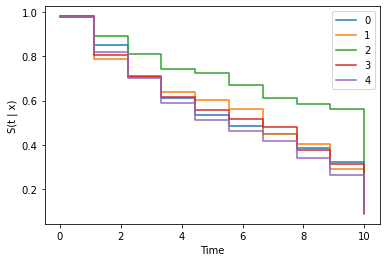

In [17]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [18]:
surv = model.interpolate(10).predict_surv_df(x_test)

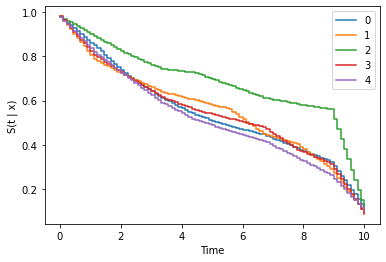

In [19]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [20]:
# evaluation

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [21]:
ev.concordance_td('antolini')

0.6772879874451221

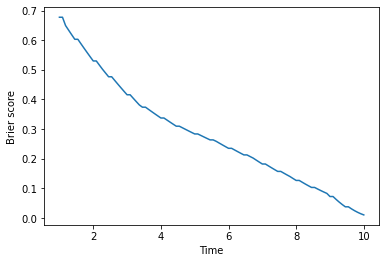

In [22]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

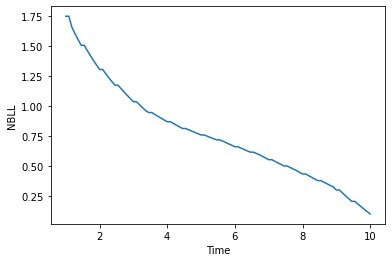

In [23]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [24]:
ev.integrated_brier_score(time_grid) 

0.2827576403683873

In [25]:
ev.integrated_nbll(time_grid) 

0.7662886282875381